<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Linear Regression

_Authors: Kevin Markham (DC), Ed Podojil (NYC)_

#### Learning Objectives
- Define data modeling and simple linear regression.
- Build a linear regression model using a dataset that meets the linearity assumption using the sci-kit learn library.
- Understand and identify multicollinearity in a multiple regression.

### Lesson Guide
- [Introduce the bikeshare dataset](#introduce-the-bikeshare-dataset)
	- [Read in the  Capital Bikeshare data](#read-in-the--capital-bikeshare-data)
	- [Visualizing the data](#visualizing-the-data)
- [Linear regression basics](#linear-regression-basics)
	- [Form of linear regression](#form-of-linear-regression)
- [Overview of supervised learning](#overview-of-supervised-learning)
	- [Benefits and drawbacks of scikit-learn](#benefits-and-drawbacks-of-scikit-learn)
	- [Requirements for working with data in scikit-learn](#requirements-for-working-with-data-in-scikit-learn)
	- [Building a linear regression model in sklearn](#building-a-linear-regression-model-in-sklearn)
	- [scikit-learn's 4-step modeling pattern](#scikit-learns--step-modeling-pattern)
- [Build a linear regression model](#build-a-linear-regression-model)
- [Using the model for prediction](#using-the-model-for-prediction)
	- [Does the scale of the features matter?](#does-the-scale-of-the-features-matter)
- [Work with multiple features](#work-with-multiple-features)
	- [Visualizing the data (part 2)](#visualizing-the-data-part-)
	- [Adding more features to the model](#adding-more-features-to-the-model)
- [What is Multicollinearity?](#what-is-multicollinearity)
- [How to select a model](#how-to-select-a-model)
	- [Feature selection](#feature-selection)
	- [Evaluation metrics for regression problems](#evaluation-metrics-for-regression-problems)
	- [Comparing models with train/test split and RMSE](#comparing-models-with-traintest-split-and-rmse)
	- [Comparing testing RMSE with null RMSE](#comparing-testing-rmse-with-null-rmse)
- [Feature engineering to improve performance](#feature-engineering-to-improve-performance)
	- [Handling categorical features](#handling-categorical-features)
	- [Feature engineering](#feature-engineering)
- [Bonus material: Regularization](#bonus-material-regularization)
	- [How does regularization work?](#how-does-regularization-work)
	- [Lasso and ridge path diagrams](#lasso-and-ridge-path-diagrams)
	- [Advice for applying regularization](#advice-for-applying-regularization)
	- [Ridge regression](#ridge-regression)
- [Comparing linear regression with other models](#comparing-linear-regression-with-other-models)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14
plt.style.use("fivethirtyeight")

<a id="introduce-the-bikeshare-dataset"></a>
## Introduce the bikeshare dataset
---

We'll be working with a dataset from Capital Bikeshare that was used in a Kaggle competition ([data dictionary](https://www.kaggle.com/c/bike-sharing-demand/data)).

The objective of the competition is to predict total ridership of Capital Bikeshare in any given hour.

Demand forecasting is a common data science application. If we can predict the quantity of demand, total ridership in a given hour, we can create analytical tools to improve the bikeshare system. 
Some applications would be:
* Find where to site new bikeshare stations and know how large of a station to build.
* Calculate the expected wear and tear on bikes and what the replacement costs will be.
* Sometimes bikeshare stations have no bikes or are completely full and prevent use of the station. With a slightly different research design we can forecast full and empty stations and send a service vehicle to "rebalance" the bikes from one station to another.

Businesses aren't new to demand forecasting, but older methods suffered from poor predictions at atypical small locations. Modern approaches incorporate clusters and online data from Twitter and Google trends to improve prediction in these small locations.

<a id="read-in-the--capital-bikeshare-data"></a>
### Read in the  Capital Bikeshare data

In [2]:
# read the data and set the datetime as the index
url = './assets/dataset/bikeshare.csv'
bikes = pd.read_csv(url, index_col='datetime', parse_dates=True)
# bikes = pd.read_csv(url)
# bikes

Notice that we used index_col to set an index or primary key for our data. In this case every row is defined by the datetime variable. 

We also ask Pandas to parse dates so rather than reading in a string, Pandas converts the string to a datetime object with a lot of great features.

In [3]:
# Preview the first 5 rows of the dataframe
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### What does each observation represent?

In [4]:
# A:
# each observation represents the conditions and number of rentals per hour

#### What is the response variable (as defined by Kaggle)?

In [5]:
# A: 
# the response variable is the dependent variable
# count = casual + registered
# count is later renamed to total since Pandas has a count method

#### How many features are there?

In [6]:
# A:
# 10 independent variables?
bikes.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

| Variable| Description |
|---------|----------------|
|datetime| hourly date + timestamp  |
|season|  1 = spring, 2 = summer, 3 = fall, 4 = winter |
|holiday| whether the day is considered a holiday|
|workingday| whether the day is neither a weekend nor holiday|
|weather| 1: Clear, 2: Mist, 3: Light Snow 4: Heavy Rain|
|temp| temperature in Celsius|
|atemp| "feels like" temperature in Celsius|
|humidity| relative humidity|
|windspeed| wind speed|
|casual| number of non-registered user rentals initiated|
|registered| number of registered user rentals initiated|
|count| number of total rentals|

#### "count" is a method in Pandas, so it's best to name that column something else

In [7]:
# Use the .rename() method to rename count to total
bikes.rename(columns={'count':'total'}, inplace=True)

In [8]:
bikes.head()   # "total" col name replaces "count" col name

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<a id="visualizing-the-data"></a>
### Visualizing the data

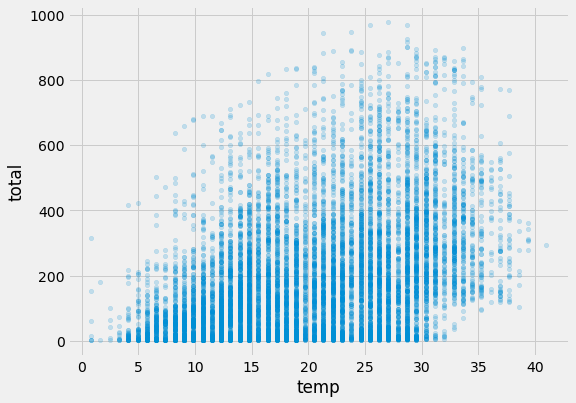

In [9]:
# Pandas scatter plot - use .plot()
# bikes.plot(kind='scatter', x='temp', y='total', alpha=0.2);   # ";" conceals the object
bikes.plot(kind='scatter', x='temp', y='total', alpha=0.2)

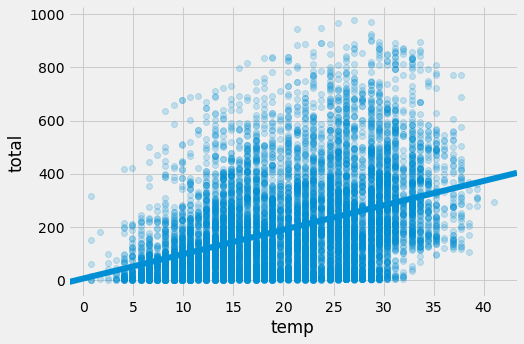

In [10]:
# Seaborn scatter plot with regression line - use sns.lmplot()
sns.lmplot(x='temp', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2})

<a id="linear-regression-basics"></a>
## Linear Regression Basics
---

<a id="form-of-linear-regression"></a>
### Form of linear regression

$y = \alpha + \beta X + \epsilon$

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n + \epsilon$

- $y$ is the response
- $\beta_0$ is the intercept
- $\beta_1$ is the coefficient for $x_1$ (the first feature)
- $\beta_n$ is the coefficient for $x_n$ (the nth feature)

The $\beta$ values are called the **model coefficients**:

- These values are estimated (or "learned") during the model fitting process using the **least squares criterion**.
- Specifically, we are try to find the line (mathematically) which minimizes the **sum of squared residuals** (or "sum of squared errors").
- And once we've learned these coefficients, we can use the model to predict the response.

![Estimating coefficients](./assets/images/estimating_coefficients.png)

In the diagram above:

- The black dots are the **observed values** of x and y.
- The blue line is our **least squares line**.
- The red lines are the **residuals**, which are the vertical distances between the observed values and the least squares line.

<a id="overview-of-supervised-learning"></a>
## Overview of supervised learning
---

![Supervised learning diagram](./assets/images/supervised_learning.png)

<a id="benefits-and-drawbacks-of-scikit-learn"></a>
### Benefits and drawbacks of scikit-learn

**Benefits:**

- Consistent interface to machine learning models
- Provides many tuning parameters but with sensible defaults
- Exceptional documentation
- Rich set of functionality for companion tasks
- Active community for development and support

**Potential drawbacks:**

- Harder (than R) to get started with machine learning
- Less emphasis (than R) on model interpretability

Ben Lorica: [Six reasons why I recommend scikit-learn](http://radar.oreilly.com/2013/12/six-reasons-why-i-recommend-scikit-learn.html)

<a id="requirements-for-working-with-data-in-scikit-learn"></a>
### Requirements for working with data in scikit-learn

1. Features and response should be **separate objects**  -  X (features) and y (response)
2. Features and response should be entirely **numeric**
3. Features and response should be **NumPy arrays** (or easily converted to NumPy arrays)  -  or Pandas Dataframe
4. Features and response should have **specific shapes** (outlined below)  -  y must be 1-dim Series, and X must be 2-dim NumPy array (even if you're using only a single feature) or a Pandas Dataframe

<a id="building-a-linear-regression-model-in-sklearn"></a>
### Building a linear regression model in sklearn

#### Create a feature matrix called X that holds a dataframe with only the temp variable and a Series called y that has the total column.

In [27]:
# create X and y
feature_cols = ['temp']
X = bikes[feature_cols]
y = bikes.total

In [12]:
print X.head()
print y.head()

                     temp
datetime                 
2011-01-01 00:00:00  9.84
2011-01-01 01:00:00  9.02
2011-01-01 02:00:00  9.02
2011-01-01 03:00:00  9.84
2011-01-01 04:00:00  9.84
datetime
2011-01-01 00:00:00    16
2011-01-01 01:00:00    40
2011-01-01 02:00:00    32
2011-01-01 03:00:00    13
2011-01-01 04:00:00     1
Name: total, dtype: int64


In [13]:
# check X's type
print(type(X))
print(type(X.values))

<class 'pandas.core.frame.DataFrame'>
<type 'numpy.ndarray'>


In [14]:
# check y's type
print(type(y))
print(type(y.values))

<class 'pandas.core.series.Series'>
<type 'numpy.ndarray'>


In [15]:
# check X's shape (n = number of observations, p = number of features)
print(X.shape)   # 2-dimensional

(10886, 1)


In [29]:
# check y's shape (single dimension with length n)
print(y.shape) # 1-dimensional

(10886,)


<a id="scikit-learns--step-modeling-pattern"></a>
## scikit-learn's 4-step modeling pattern - WILL BE USED THROUGHOUT THIS CLASS

**Step 1:** Import the class you plan to use

In [30]:
from sklearn.linear_model import LinearRegression   # see http://scikit-learn.org/stable/

**Step 2:** "Instantiate" the "estimator"

- "Estimator" is scikit-learn's term for "model"
- "Instantiate" means "make an instance of"

In [31]:
# make an instance of a LinearRegression object
lr = LinearRegression()
type(lr)

sklearn.linear_model.base.LinearRegression

- Created an object that "knows" how to do linear regression, and is just waiting for data.
- Name of the object does not matter.
- Can specify tuning parameters (aka "hyperparameters") during this step.
- All parameters not specified are set to their defaults.

**Step 3:** Fit the model with data (aka "model training")

- Model is "learning" the relationship between X and y in our "training data".
- Process through which learning occurs varies by model.
- Occurs in-place.

In [32]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

- Once a model has been fit with data, it's called a "fitted model".

**Step 4:** Predict the response for a new observation.

- New observations are called "out-of-sample" data.
- Uses the information it learned during the model training process.

In [33]:
# per future warming, prediction for a 1-dimensional arrays must be reshaped using the following:
# .reshape(1, -1) converts the 1 valued 1-dimensional np.array into a 1x1 matrix
lr.predict(np.array([0]).reshape(1,-1))
# result is in number of rides

array([ 6.04621296])

In [34]:
# predict 2 values
X_new = [[0], [10]]
lr.predict(X_new)
# result is in number of rides for temp of 0 and 10 degrees

array([  6.04621296,  97.75161777])

- Returns a NumPy array, and we keep track of what the numbers "mean".
- Can predict for multiple observations at once.

_What we just predicted using our model is " if the temperatue is 0 degrees the total number of bike rentals will be ~6.046, and if the temperature is 10 degrees the total number of bike rentals will ~97.751"_

<a id="build-a-linear-regression-model"></a>
## Build a linear regression model
---

#### Instantiate and fit a LinearRegression model on X and y from the linear_model section of scikit-learn.

In [35]:
# import, instantiate, fit
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
# print the coefficients
print linreg.intercept_   # at X = 0 degrees
print linreg.coef_        # feature (number of bikes) coefficient, is the slope
                          #   so, for X=10 degrees * the slope 9.17 = 91.7 bikes

6.04621295962
[ 9.17054048]


Interpreting the **intercept** ($\beta_0$):

- It is the value of $y$ when $x$=0.
- Thus, it is the estimated number of rentals when the temperature is 0 degrees Celsius.
- **Note:** It does not always make sense to interpret the intercept. (Why?)
- A: X=0 may not be relevant for range of inputs 

Interpreting the **"temp" coefficient** ($\beta_1$):

- It is the change in $y$ divided by change in $x$, or the "slope".
- Thus, a temperature increase of 1 degree Celsius is **associated with** a rental increase of 9.17 bikes.
- This is not a statement of causation.
- $\beta_1$ would be **negative** if an increase in temperature was associated with a **decrease** in rentals.

<a id="using-the-model-for-prediction"></a>
## Using the model for prediction
---

While there is plenty of insight that can be found in reading coefficients, the most common uses of data science focus of prediction. In scikit-learn we can make predictions from a fitted model using `.predict()`, but we will also go through the calculation by hand to understand it.

#### How many bike rentals would we predict if the temperature was 25 degrees Celsius?

#### Explore the intercept and coefficients of the linear model

You can search for "sklearn linear regression" and explore the attributes section of the documentation to learn how to do this.

In [37]:
# manually calculate the prediction

linreg.intercept_ + linreg.coef_*25

array([ 235.309725])

$temp_x$ = $\beta_0$ + $\beta_1$*$X_1$

In [38]:
# use the predict method
linreg.predict(25)

array([ 235.309725])

<a id="does-the-scale-of-the-features-matter"></a>
### Does the scale of the features matter?

Let's say that temperature was measured in Fahrenheit, rather than Celsius. How would that affect the model?

In [17]:
# create a new column for Fahrenheit temperature
bikes['temp_F'] = bikes.temp * 1.8 + 32
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,temp_F
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,49.712
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,48.236
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,48.236
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,49.712
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,49.712


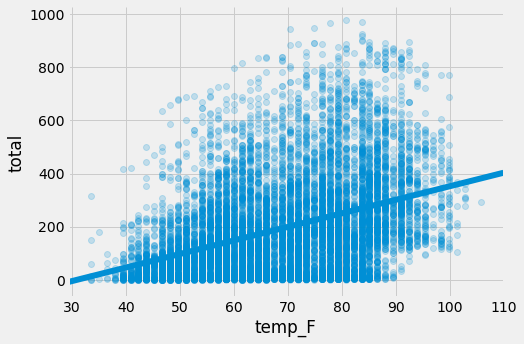

In [19]:
# Seaborn scatter plot with regression line
sns.lmplot(x='temp_F', y='total', data=bikes, aspect=1.5, scatter_kws={'alpha':0.2});

#### Rebuild the LinearRegression from above using the temp_F features instead.

In [21]:
from sklearn.linear_model import LinearRegression

# create X and y
feature_cols = ['temp_F']
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

-156.985617821
[ 5.09474471]


#### Convert 25 degrees Celsius to Fahrenheit

In [22]:
25 * 1.8 + 32

77.0

#### Predict rentals for 77 degrees Fahrenheit

In [23]:
linreg.predict(77)

array([ 235.309725])

**Conclusion:** The scale of the features is **irrelevant** for linear regression models. When changing the scale, we simply change our **interpretation** of the coefficients.

In [24]:
# remove the temp_F column
bikes.drop('temp_F', axis=1, inplace=True)

In [25]:
bikes.head()  column  # no temp_F

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<a id="work-with-multiple-features"></a>
## Work with multiple features
---

We've demonstrated simple linear regression with one feature to gain an intuition, but the benefit of modeling is the ability to reason about hundreds of features at once. We can start with four.

<a id="visualizing-the-data-part-"></a>
### Visualizing the data (part 2)

#### Explore more features.

In [39]:
# Create a features col variables that has temp, season, weather, and humidity
feature_cols = ['temp', 'season', 'weather', 'humidity']

#### Create a subset of scatterplot matrix using Seaborn
We can use pairplot with the **y_vars argument** to only show relationships with the total variable

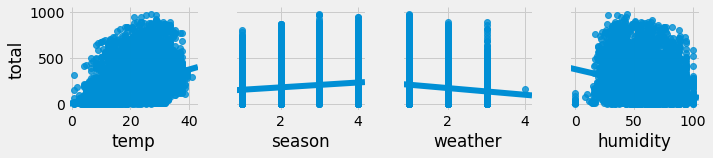

In [47]:
# multiple scatter plots in Seaborn - recommended
sns.pairplot(bikes, x_vars=feature_cols, y_vars='total', kind='reg')   # plot features against "total" column, only

#### Recreate the same functionality using Pandas

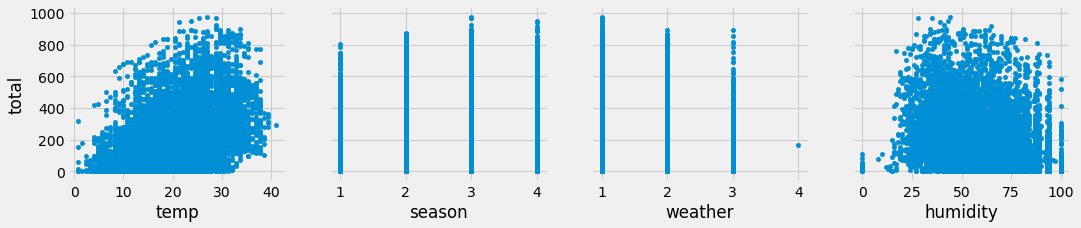

In [41]:
# multiple scatter plots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    bikes.plot(kind='scatter', x=feature, y='total', ax=axs[index], figsize=(16, 3))

#### Are you seeing anything that you did not expect?

A: Winter [4] has greater ridership than spring [1] due to growing business!

#### Explore the season variable using a cross-tab

In [42]:
# cross-tabulation of season and month
pd.crosstab(bikes.season, bikes.index.month)

col_0,1,2,3,4,5,6,7,8,9,10,11,12
season,,,,,,,,,,,,
1,884,901,901,0,0,0,0,0,0,0,0,0
2,0,0,0,909,912,912,0,0,0,0,0,0
3,0,0,0,0,0,0,912,912,909,0,0,0
4,0,0,0,0,0,0,0,0,0,911,911,912


#### Explore the season variable using a box-plot

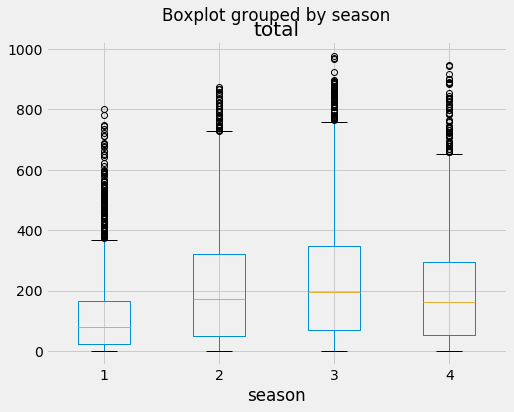

In [43]:
# box plot of rentals, grouped by season
bikes.boxplot(column='total', by='season');

Notably:

- A line can't capture a non-linear relationship.
- There are more rentals in winter [4] than in spring [1] (?)

#### Look at rentals over time.

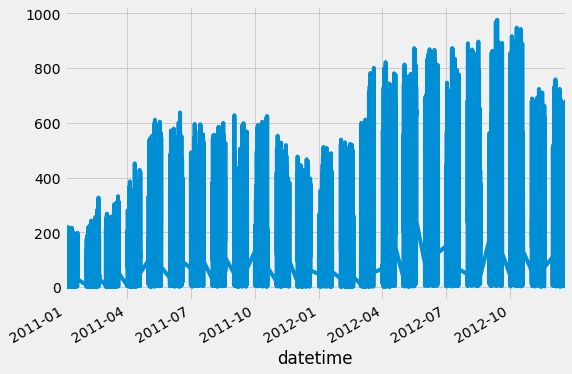

In [48]:
# line plot of rentals
bikes.total.plot()

#### What does this tell us?

There are more rentals in the winter than the spring, but only because the system is experiencing **overall growth** and the winter months happen to come after the spring months.

#### Look at the correlation matrix for the bikes dataframe.

In [49]:
# correlation matrix (ranges from 1 to -1)
bikes.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


#### Use a heatmap to make it easier to read the correlation matrix.

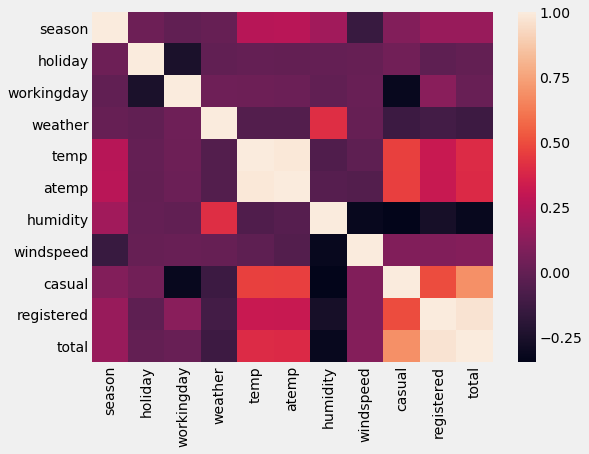

In [50]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bikes.corr());

#### What relationships do you notice?

In [ ]:
# A: temp and time of day (?)

<a id="adding-more-features-to-the-model"></a>
### Adding more features to the model

In the previous example, one variable explained the variance of another; however, more often than not, we will need multiple variables. 

- For example, a house's price may be best measured by square feet, but a lot of other variables play a vital role: bedrooms, bathrooms, location, appliances, etc. 

- For a linear regression, we want these variables to be largely independent of each other, but all of them should help explain the y variable.

We'll work with bike-share data to showcase what this means and to explain a concept called **multicollinearity**.

#### Create another LinearRegression instance that is fit using temp, season, weather, and humidity.

In [51]:
# create a list of features
feature_cols = ['temp', 'season', 'weather', 'humidity']

In [52]:
# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

159.520687861
[  7.86482499  22.53875753   6.67030204  -3.11887338]


#### Display the linear regression coefficient along with the feature names.

In [53]:
# pair the feature names with the coefficients
zip(feature_cols, linreg.coef_)

[('temp', 7.864824992477442),
 ('season', 22.538757532466779),
 ('weather', 6.6703020359237426),
 ('humidity', -3.1188733823964956)]

Interpreting the coefficients:

- Holding all other features fixed, a 1 unit increase in **temperature** is associated with a **rental increase of 7.86 bikes**.
- Holding all other features fixed, a 1 unit increase in **season** is associated with a **rental increase of 22.5 bikes**.
- Holding all other features fixed, a 1 unit increase in **weather** is associated with a **rental increase of 6.67 bikes**.
- Holding all other features fixed, a 1 unit increase in **humidity** is associated with a **rental decrease of 3.12 bikes**.

Does anything look incorrect and does not reflect reality?

<a id="what-is-multicollinearity"></a>
## What is Multicollinearity?
---

Multicollinearity happens when two or more features are highly-correlated with each other. The problem is that due to the high correlation, it's hard to disambiguate which feature has what kind of effect on the outcome. In other words, the features mask each other. 

There is a second related issue called variance inflation where including correlated features increases the variability of our model and p-values by widening the standard errors. This can be measured with the Variance Inflation Factor which we will not cover here.

#### With the bikeshare data, let's compare three data points: actual temperature, "feel" temperature, and guest ridership.

            temp     atemp    casual
temp    1.000000  0.984948  0.467097
atemp   0.984948  1.000000  0.462067
casual  0.467097  0.462067  1.000000
Axes(0.08,0.07;0.696x0.81)


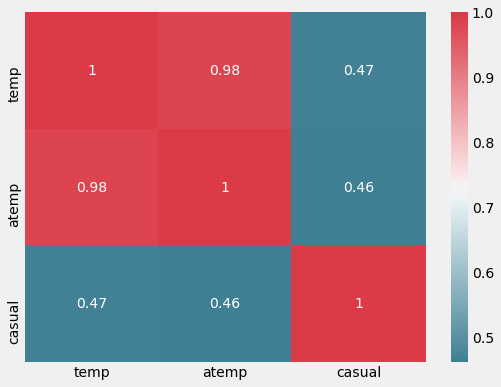

In [55]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
correlations = bikes[['temp', 'atemp', 'casual']].corr()
print correlations
print sns.heatmap(correlations, cmap=cmap, annot=True)

#### Create a linear model that predict 'total' using 'temp' and 'atemp'.

In [56]:
# create a list of features
feature_cols = ['temp', 'atemp']

In [57]:
# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

4.2481326458
[ 8.19865874  0.90720808]


#### Go back and remove either temp or atemp from the feature list. How do the coefficients change? 

In [65]:
# A:

# create a list of features
# feature_cols = ['temp', 'atemp'] # original
feature_cols = ['temp', 'atemp']   # try swapping order: order matters; "temp" overshadows "atemp"
# feature_cols = ['temp']
# feature_cols = ['atemp']

# create X and y
X = bikes[feature_cols]
y = bikes.total

# instantiate and fit
linreg = LinearRegression()
linreg.fit(X, y)

# print the coefficients
print linreg.intercept_
print linreg.coef_

4.2481326458
[ 8.19865874  0.90720808]


A: Coefficients change when combined (temp alone has different value than temp with atemp).  If little to no effect, indicates little to no correlation.  If large change, one may overshadow the effect of the other.

<a id="how-to-select-a-model"></a>
## How to select a model
---

We can make linear models now, but how do we select the best model to use for our applications? We will offer a general procedure and a simple metric that works well in many cases, but it's important to keep the business context in mind and know that there are alternative metrics that can work better.

<a id="feature-selection"></a>
### Feature selection

How do we choose which features to include in the model? We're going to use **train/test split** (and eventually **cross-validation**).

Why not use of **p-values** or **R-squared** for feature selection?

- Linear models rely upon **a lot of assumptions** (such as the features being independent), and if those assumptions are violated, p-values and R-squared are less reliable. Train/test split relies on fewer assumptions.
- Features that do not cause the response can still have **significant p-values**.
- Adding features to your model that are unrelated to the response will always **increase the R-squared value**, and adjusted R-squared does not sufficiently account for this. (Although, AIC and BIC do.)
- p-values and R-squared are **proxies** for our goal of generalization, whereas train/test split and cross-validation attempt to **directly estimate** how well the model will generalize to out-of-sample data.

More generally:

- There are different methodologies that can be used for solving any given data science problem, and this course follows a **machine learning methodology**.
- This course focuses on **general purpose approaches** that can be applied to any model, rather than model-specific approaches.

<a id="evaluation-metrics-for-regression-problems"></a>
### Evaluation metrics for regression problems

Evaluation metrics for classification problems, such as **accuracy**, are not useful for regression problems. We need evaluation metrics designed for comparing **continuous values**.

Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

In [66]:
# example true and predicted response values
true = [10, 7, 5, 5]
pred = [8, 6, 5, 10]

#### Calculate MAE, MSE, and RMSE using imports from sklearn metrics and numpy.

In [67]:
# calculate these metrics by hand!
from sklearn import metrics
import numpy as np
print 'MAE:', metrics.mean_absolute_error(true, pred)
print 'MSE:', metrics.mean_squared_error(true, pred)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(true, pred))

MAE: 2.0
MSE: 7.5
RMSE: 2.73861278753


Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.

All of these are **loss functions**, because we want to minimize them (minimize the errors).

Here's an additional example, to demonstrate how MSE/RMSE punishes larger errors:

In [68]:
# same true values as above
true = [10, 7, 5, 5]

# new set of predicted values
pred = [10, 7, 5, 13]

# MAE is the same as before
print 'MAE:', metrics.mean_absolute_error(true, pred)

# MSE and RMSE are larger than before
print 'MSE:', metrics.mean_squared_error(true, pred)
print 'RMSE:', np.sqrt(metrics.mean_squared_error(true, pred))

MAE: 2.0
MSE: 16.0
RMSE: 4.0


<a id="comparing-models-with-traintest-split-and-rmse"></a>
### Comparing models with train/test split and RMSE

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
# from sklearn.model_selection import train_test_split
# do multiple times to determine best model (features?) that produces the lowest error
# then retrain the model on all of the data

# define a function that accepts a list of features and returns testing RMSE
def train_test_rmse(feature_cols):
    X = bikes[feature_cols]
    y = bikes.total
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)  # default is 80/20 train/test split
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)                                 # 80% train, solves linear equation to determine beta coefficients
    y_pred = linreg.predict(X_test)                              # 20% test (predict), uses beta coefficients to make predictions
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))   # compares the test and predictions to determine error

In [81]:
# compare different sets of features (order doesn't matter)
print train_test_rmse(['temp', 'season', 'weather', 'humidity'])
print train_test_rmse(['temp', 'season', 'weather'])
print train_test_rmse(['temp', 'season', 'humidity'])  # lowest error is the best case, when weather is removed

155.649459131
164.165399763
155.598189367


In [82]:
# using these as features is not allowed! - zero error, perfect prediction
train_test_rmse(['casual', 'registered'])

1.0601428880347174e-13

<a id="comparing-testing-rmse-with-null-rmse"></a>
### Comparing testing RMSE with null RMSE

Null RMSE is the RMSE that could be achieved by **always predicting the mean response value**. It is a benchmark against which you may want to measure your regression model.

Note: It is good to always do this. This is a great way to evaluate whether your model is better than intuition. You may want to use mean or median (if the mean is heavily influenced by outliers)

Q: When and why would we want to use this?

In [83]:
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

# create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null

array([ 192.26451139,  192.26451139,  192.26451139, ...,  192.26451139,
        192.26451139,  192.26451139])

In [84]:
# compute null RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_null))

179.57906896465727

<a id="feature-engineering-to-improve-performance"></a>
## Feature engineering to improve performance
---

Machine learning models are very powerful, but they cannot automatically handle every aspect of our data. We have to explicitly modify our features to have relationships that our models can understand. In this case, we will need to pull out features to have a linear relationship with our response variable.


<a id="handling-categorical-features"></a>
<a id="handling-categorical-features"></a>
<a id="handling-categorical-features"></a>
<a id="handling-categorical-features"></a>
### Handling categorical features

scikit-learn expects all features to be numeric. So how do we include a categorical feature in our model?

- **Ordered categories:** transform them to sensible numeric values (example: small=1, medium=2, large=3)
- **Unordered categories:** use dummy encoding (0/1)

What are the categorical features in our dataset?

- **Ordered categories:** weather (already encoded with sensible numeric values)
- **Unordered categories:** season (needs dummy encoding), holiday (already dummy encoded), workingday (already dummy encoded)

For season, we can't simply leave the encoding as 1 = spring, 2 = summer, 3 = fall, and 4 = winter, because that would imply an **ordered relationship**. Instead, we create **multiple dummy variables:**

#### Create dummy variables using get_dummies from Pandas.

In [ ]:
season_dummies = pd.get_dummies(bikes.season, prefix='season')

#### Inspect the dataframe of dummies.

In [ ]:
# print 5 random rows
season_dummies.sample(n=5, random_state=1)

However, we actually only need **three dummy variables (not four)**, and thus we'll drop the first dummy variable.

Why? Because three dummies captures all of the "information" about the season feature, and implicitly defines spring (season 1) as the **baseline level:**.

This circles back to the concept multicollinearity, except instead of 1 feature being highly coorelated to another, the information gained from three features is directly coorelated to the fourth.

#### Drop the first column.

In [ ]:
season_dummies.drop(season_dummies.columns[0], axis=1, inplace=True)

#### Reinspect the dataframe of dummies.

In [ ]:
# print 5 random rows
season_dummies.sample(n=5, random_state=1)

In general, if you have a categorical feature with **k possible values**, you create **k-1 dummy variables**.

If that's confusing, think about why we only need one dummy variable for holiday, not two dummy variables (holiday_yes and holiday_no).

#### We now need to concatenate the two dataframe together

In [ ]:
# concatenate the original DataFrame and the dummy DataFrame (axis=0 means rows, axis=1 means columns)
bikes = pd.concat([bikes, season_dummies], axis=1)

# print 5 random rows
bikes.sample(n=5, random_state=1)

#### Rerun the linear regression with dummy variables included

In [ ]:
# include dummy variables for season in the model
feature_cols = ['temp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes[feature_cols]
y = bikes.total
linreg = LinearRegression()
linreg.fit(X, y)
zip(feature_cols, linreg.coef_)

How do we interpret the season coefficients? They are **measured against the baseline (spring)**:

- Holding all other features fixed, **summer** is associated with a **rental decrease of 3.39 bikes** compared to the spring.
- Holding all other features fixed, **fall** is associated with a **rental decrease of 41.7 bikes** compared to the spring.
- Holding all other features fixed, **winter** is associated with a **rental increase of 64.4 bikes** compared to the spring.

Would it matter if we changed which season was defined as the baseline?

- No, it would simply change our **interpretation** of the coefficients.

_In most situations it is best to have your the dummy that your drop, your baseline, be the category that has the largest representation.  _

**Important:** Dummy encoding is relevant for all machine learning models, not just linear regression models.

In [ ]:
# compare original season variable with dummy variables
print train_test_rmse(['temp', 'season', 'humidity'])
print train_test_rmse(['temp', 'season_2', 'season_3', 'season_4', 'humidity'])

<a id="feature-engineering"></a>
### Feature engineering

See if you can create the following features:

- **hour:** as a single numeric feature (0 through 23)
- **hour:** as a categorical feature (use 23 dummy variables)
- **daytime:** as a single categorical feature (daytime=1 from 7am to 8pm, and daytime=0 otherwise)

Then, try using each of the three features (on its own) with `train_test_rmse` to see which one performs the best!

#### Extract hour of the day to use as a feature

In [ ]:
bikes['hour'] = bikes.index.hour

#### Enccode hour as a categorical feature

In [ ]:
hour_dummies = pd.get_dummies(bikes.hour, prefix='hour')
hour_dummies.drop(hour_dummies.columns[0], axis=1, inplace=True)
bikes = pd.concat([bikes, hour_dummies], axis=1)

#### Generate a daytime variables based on hour of the day

In [ ]:
bikes['daytime'] = ((bikes.hour > 6) & (bikes.hour < 21)).astype(int)

#### Test the Root Mean Squared Error of our various hour encodings

In [ ]:
print train_test_rmse(['hour'])
print train_test_rmse(bikes.columns[bikes.columns.str.startswith('hour_')])
print train_test_rmse(['daytime'])

<a id="bonus-material-regularization"></a>
## Bonus material: Regularization
---

- Regularization is a method for "constraining" or "regularizing" the **size of the coefficients**, thus "shrinking" them towards zero.
- It reduces model variance and thus **minimizes overfitting**.
- If the model is too complex, it tends to reduce variance more than it increases bias, resulting in a model that is **more likely to generalize**.

Our goal is to locate the **optimum model complexity**, and thus regularization is useful when we believe our model is too complex.

<a id="how-does-regularization-work"></a>
<a id="how-does-regularization-work"></a>
<a id="how-does-regularization-work"></a>
<a id="how-does-regularization-work"></a>
### How does regularization work?

For a normal linear regression model, we estimate the coefficients using the least squares criterion, which **minimizes the residual sum of squares (RSS):**

For a regularized linear regression model, we **minimize the sum of RSS and a "penalty term"** that penalizes coefficient size.

**Ridge regression** (or "L2 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p \beta_j^2$$

**Lasso regression** (or "L1 regularization") minimizes: $$\text{RSS} + \alpha \sum_{j=1}^p |\beta_j|$$

- $p$ is the **number of features**
- $\beta_j$ is a **model coefficient**
- $\alpha$ is a **tuning parameter:**
    - A tiny $\alpha$ imposes no penalty on the coefficient size, and is equivalent to a normal linear regression model.
    - Increasing the $\alpha$ penalizes the coefficients and thus shrinks them.

<a id="lasso-and-ridge-path-diagrams"></a>
<a id="lasso-and-ridge-path-diagrams"></a>
<a id="lasso-and-ridge-path-diagrams"></a>
<a id="lasso-and-ridge-path-diagrams"></a>
### Lasso and ridge path diagrams

A larger alpha (towards the left of each diagram) results in more regularization:

- **Lasso regression** shrinks coefficients all the way to zero, thus removing them from the model
- **Ridge regression** shrinks coefficients toward zero, but they rarely reach zero

Source code for the diagrams: [Lasso regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html) and [Ridge regression](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)

![Lasso and Ridge Coefficient Plots](./assets/images/lasso_ridge_path.png)

<a id="advice-for-applying-regularization"></a>
<a id="advice-for-applying-regularization"></a>
<a id="advice-for-applying-regularization"></a>
<a id="advice-for-applying-regularization"></a>
### Advice for applying regularization

**Should features be standardized?**

- Yes, because otherwise, features would be penalized simply because of their scale.
- Also, standardizing avoids penalizing the intercept, which wouldn't make intuitive sense.

**How should you choose between Lasso regression and Ridge regression?**

- Lasso regression is preferred if we believe many features are irrelevant or if we prefer a sparse model.
- Ridge can work particularly well if there is a high degree of multicolinearity in your model.
- If model performance is your primary concern, it is best to try both.
- ElasticNet regression is a combination of lasso regression and ridge Regression.

<a id="ridge-regression"></a>
<a id="ridge-regression"></a>
<a id="ridge-regression"></a>
<a id="ridge-regression"></a>
### Ridge regression

- [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) documentation
- **alpha:** must be positive, increase for more regularization
- **normalize:** scales the features (without using StandardScaler)

In [ ]:
# include dummy variables for season in the model
feature_cols = ['temp', 'atemp', 'season_2', 'season_3', 'season_4', 'humidity']
X = bikes[feature_cols]
y = bikes.total

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# alpha=0 is equivalent to linear regression
from sklearn.linear_model import Ridge
# instantiate the model 
#(alpha of zero has no regularization strength, essentially a basic linear regression)
ridgereg = Ridge(alpha=0, normalize=True)
# fit the model
ridgereg.fit(X_train, y_train)
# redict with fitted model
y_pred = ridgereg.predict(X_test)
print np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
# coefficients for a non-regularized linear regression
zip(feature_cols, ridgereg.coef_)

To interpret these coefficients we need to convert them back to original units, which is a reason to do normalization by hand. However, in this form the coefficients have a special meaning. The intercept is now the average of our outcome, and the magnitude of each coefficient in the model is a measure of how important it is in the model. We call this feature importance.

In [ ]:
# try alpha=0.1
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print np.sqrt(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
# examine the coefficients
zip(feature_cols, ridgereg.coef_)

While the MSE barely improved, we can see there are significant changes in the weight of our coefficients.  Particularly `season_2` whose coefficent has greatly decreased towards 0.

Fitting and using a Lasso Regression in SKLearn is the same.  

In addition to the typical [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) and [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) there is a third type of regression, [Elastic Net](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) which combines the penalties of the Ridge and Lasso methods.

<a id="comparing-linear-regression-with-other-models"></a>
## Comparing linear regression with other models

Advantages of linear regression:

- Simple to explain
- Highly interpretable
- Model training and prediction are fast
- No tuning is required (excluding regularization)
- Features don't need scaling
- Can perform well with a small number of observations
- Well-understood

Disadvantages of linear regression:

- Presumes a linear relationship between the features and the response
- Performance is (generally) not competitive with the best supervised learning methods due to high bias
- Can't automatically learn feature interactions